Train a downstream model using the GNN embeddings as additional features for the model

In [2]:
from src.elliptic_baseline_preprocessing import create_table

# Enter the following details:
pipeline_uri = "65ea7a869fac4a0590779f7206b25e04"

enhanced_table = create_table(store, pipeline_uri, type = "gnn_enhanced")

Table deleted: katana-clusters-beta.fsi_elliptic.auto_ml_enhanced_gnn_training_65ea7a869fac4a0590779f7206b25e04
Loaded 203769 rows and 111 columns to katana-clusters-beta.fsi_elliptic.auto_ml_enhanced_gnn_training_65ea7a869fac4a0590779f7206b25e04
Creating TabularDataset
Create TabularDataset backing LRO: projects/936152536067/locations/us-central1/datasets/5298082540345622528/operations/4910148793384566784
TabularDataset created. Resource name: projects/936152536067/locations/us-central1/datasets/5298082540345622528
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/936152536067/locations/us-central1/datasets/5298082540345622528')
	Dataset: "elliptic_enhanced_training_dataset"
	name: "projects/936152536067/locations/us-central1/datasets/5298082540345622528"


In [4]:
from google.cloud import aiplatform

enhanced_classification_job = aiplatform.AutoMLTabularTrainingJob(
    display_name="elliptic_enhanced_training_job_test", 
    optimization_prediction_type="classification"
)

enhanced_model = enhanced_classification_job.run(
    dataset=enhanced_table,
    target_column="target",
    budget_milli_node_hours=800,
    model_display_name="elliptic_gnn_enhanced_gs_test",
    disable_early_stopping=False,
    predefined_split_column_name="split_str",
    sync=False
)

No column transformations provided, so now retrieving columns from dataset in order to set default column transformations.
The column transformation of type 'auto' was set for the following columns: ['local_feat_47', 'local_feat_84', 'embed_12', 'local_feat_85', 'embed_11', 'local_feat_12', 'local_feat_50', 'local_feat_78', 'local_feat_91', 'local_feat_27', 'local_feat_38', 'local_feat_23', 'embed_15', 'local_feat_71', 'local_feat_4', 'embed_9', 'embed_10', 'local_feat_55', 'local_feat_76', 'local_feat_29', 'local_feat_69', 'local_feat_72', 'local_feat_44', 'split_str', 'embed_7', 'local_feat_77', 'local_feat_11', 'local_feat_3', 'embed_13', 'local_feat_90', 'embed_1', 'local_feat_75', 'embed_6', 'local_feat_83', 'local_feat_52', 'local_feat_24', 'local_feat_82', 'local_feat_8', 'local_feat_30', 'local_feat_10', 'local_feat_57', 'local_feat_65', 'local_feat_49', 'local_feat_73', 'local_feat_94', 'local_feat_51', 'embed_8', 'local_feat_59', 'local_feat_15', 'local_feat_5', 'local_feat_1

### Go to GCP Console to monitor training job, view F1 Score, and deploy endpoint

### Elliptic XGBoost Model

In [1]:

import os                                                                        
import time                                                                      
import json
import uuid
import pandas as pd
import numpy as np
import argparse
from timeit import default_timer as timer
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import xgboost
import dask.dataframe as dd
from dask.distributed import Client
import dask_xgboost as dxgb
import dask.array as da

from src.elliptic_baseline_preprocessing import init_fs, create_table

In [2]:
client = Client(n_workers=4, threads_per_worker=1)

pipeline_uri = "65ea7a869fac4a0590779f7206b25e04"

In [3]:
# import dataframe
mapping_table = "katana-clusters-beta.fsi_elliptic.account_mapping_"+pipeline_uri
df = store.get_historical_features(
    entity_df=f"""
    SELECT 
        account_gid,
        account_id,
        event_timestamp
    FROM 
        {mapping_table}    
    """,
    features=store.get_feature_service("account_gnn_enhanced_fs"), 
    full_feature_names=False
).to_df()

In [4]:
ddf = dd.from_pandas(df, npartitions=1)
ddf.head()

,account_gid,account_id,event_timestamp,node_type,target,split,embed_0,embed_1,embed_2,embed_3,...,local_feat_85,local_feat_86,local_feat_87,local_feat_88,local_feat_89,local_feat_90,local_feat_91,local_feat_92,local_feat_93,local_feat_94
0,8843,310522842,2022-09-26 00:00:00+00:00,Classified_Acct,0,0,1.109760,0.076339,0.0,0.808370,...,-0.254929,-0.259014,1.125590,1.128038,-0.293830,-0.741721,-0.669764,-0.702908,1.135523,1.135279
1,7372,102664424,2022-09-26 00:00:00+00:00,Classified_Acct,0,2,2.129416,0.000000,0.0,0.602560,...,-0.255168,-0.259251,-0.187191,-0.185274,-0.293897,-0.745834,-0.678616,-0.710994,0.066572,0.580248
2,6819,24378551,2022-09-26 00:00:00+00:00,Unclassified_Acct,0,0,0.000000,0.474104,0.0,1.008052,...,-0.254584,-0.258672,1.125590,1.128038,-0.293870,-0.507623,-0.386640,-0.494130,1.135523,1.135279
3,1485,32994941,2022-09-26 00:00:00+00:00,Unclassified_Acct,0,0,0.000000,0.000000,0.0,0.896631,...,-0.255101,-0.259185,1.125590,1.128038,-0.293870,-0.729542,-0.655018,-0.692058,1.135523,1.135279
4,9556,310111295,2022-09-26 00:00:00+00:00,Unclassified_Acct,0,0,0.238529,0.000000,0.0,1.119680,...,-0.255159,-0.258995,-1.499972,-1.498585,-0.279627,-0.660600,-0.577964,-0.625907,-1.084907,-1.084845


In [5]:
train = ddf[(ddf.split == 0)]
test = ddf[(ddf.split == 1)]
X_train = train.iloc[:, 6:]
X_test = test.iloc[:, 6:]
y_train = train.iloc[:,4]
y_test = test.iloc[:,4]

In [6]:
new_params = {'objective': 'binary:logistic',
          'eval_metric':'logloss',
          'max_depth':10,
          'verbosity':0,
          'colsample_bytree':1,
          'scale_pos_weight':8,
          'reg_lambda':10,
         }

In [7]:
bst_embed = dxgb.train(client, new_params, X_train, y_train)
bst_embed

/home/anuhyabs_katanagraph_com/.conda/envs/feast/lib/python3.8/site-packages/dask_xgboost/tracker.py:365: DeprecationWarning: isAlive() is deprecated, use is_alive() instead
  while self.thread.isAlive():
/home/anuhyabs_katanagraph_com/.conda/envs/feast/lib/python3.8/site-packages/dask_xgboost/__init__.py:7: UserWarning: Dask-XGBoost has been deprecated and is no longer maintained. The functionality of this project has been included directly in XGBoost. To use Dask and XGBoost together, please use ``xgboost.dask`` instead https://xgboost.readthedocs.io/en/latest/tutorials/dask.html.
  warnings.warn(
[20:41:45] Tree method is automatically selected to be 'approx' for distributed training.


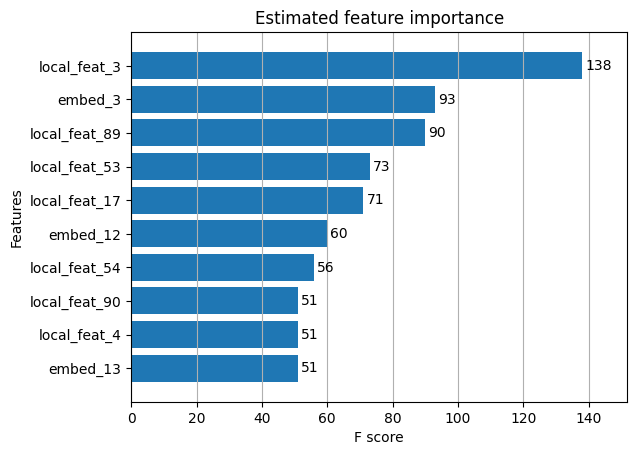

In [8]:
%matplotlib inline

ax = xgboost.plot_importance(bst_embed, height=0.8, max_num_features=10)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

In [9]:
predictions_embed = dxgb.predict(client, bst_embed, X_test).persist()
predictions_embed

dask.array<values, shape=(nan,), dtype=float32, chunksize=(nan,), chunktype=numpy.ndarray>

/home/anuhyabs_katanagraph_com/.conda/envs/feast/lib/python3.8/site-packages/dask_xgboost/__init__.py:7: UserWarning: Dask-XGBoost has been deprecated and is no longer maintained. The functionality of this project has been included directly in XGBoost. To use Dask and XGBoost together, please use ``xgboost.dask`` instead https://xgboost.readthedocs.io/en/latest/tutorials/dask.html.
  warnings.warn(


In [10]:
predictions_embed.compute()

array([0.02425236, 0.03095298, 0.02463905, ..., 0.97286725, 0.1679642 ,
       0.06612833], dtype=float32)

In [11]:
pred_embed = da.where(predictions_embed > 0.5, 1, 0).compute()
y = np.array(y_test.compute()).astype(str).astype(int)
print(f1_score(y,pred_embed))

0.750943396226415
